## Using a GPU

To begin, let's check to see if we're using a GPU. Using a GPU will make sure our model trains faster than using just a CPU.


In [ ]:
# Are we using a GPU?
!nvidia-smi

Tue Jun 27 05:01:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-06-27 05:01:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.7MB/s    in 8.7s    

2023-06-27 05:01:17 (18.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import zipfile

local = '/content/10_food_classes_10_percent.zip'
zipref = zipfile.ZipFile(local)
zipref.extractall()
zipref.close()

In [ ]:
import os
path='/content/10_food_classes_10_percent'
for dirpath, dirnames, filenames in os.walk(path):
  print(f"There are {len(dirnames)} directories, {len(filenames)} filenames in {dirpath}")

There are 2 directories, 0 filenames in /content/10_food_classes_10_percent
There are 10 directories, 0 filenames in /content/10_food_classes_10_percent/train
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/fried_rice
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/steak
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/pizza
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/chicken_curry
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/hamburger
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/grilled_salmon
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/ramen
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/chicken_wings
There are 0 directories, 75 filenames in /content/10_food_classes_10_percent/train/ice_cream
Th

Note training data is few, to demonstrate the power of Transfer learning

In [ ]:
#Preparing dataloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#hyperparameters
IMAGE_SHAPE=(224,224)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode='categorical',
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    class_mode='categorical',
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
train_generator.num_classes

10

**Callbacks**
functions to be performed or utilities called while training and at end of training
- popular
  - tensorboard - to track experiments
  - model checkpoint
  - early stopping

In [ ]:
#Create tensorborad callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving tensorboard log files to: {log_dir}")
    return tensorboard_callback

In [ ]:
# Creating models using Tensorflow Hub
##Effecientnetv2B0 feature vetcor: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
#resnetv2-50
import tensorflow_hub as hub

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'


In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
def create_model(model_url, num_classes):

    #Download the pretrained layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
##resnet mode

resnet_model = create_model(resnet_url, num_classes=train_generator.num_classes)

***Note the Non_trainable params***

In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [ ]:
#define callback
dir_name='tensorflow_hub'
experiment_name='resnet50v2'
tensorboard_callback = create_tensorboard_callback(dir_name, experiment_name)


resnet_history = resnet_model.fit(train_generator,
                 epochs=5,
                 steps_per_epoch=len(train_generator),
                 validation_data=test_generator,
                 validation_steps=len(test_generator),
                 callbacks=[tensorboard_callback])

Saving tensorboard log files to: tensorflow_hub/resnet50v2/20230627-050319
Epoch 1/5
24/24 [==============================] - 34s 847ms/step - loss: 1.9734 - accuracy: 0.3387 - val_loss: 1.2163 - val_accuracy: 0.6184
Epoch 2/5
24/24 [==============================] - 18s 773ms/step - loss: 0.9200 - accuracy: 0.7200 - val_loss: 0.8722 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 17s 746ms/step - loss: 0.6397 - accuracy: 0.7987 - val_loss: 0.7329 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 28s 1s/step - loss: 0.4811 - accuracy: 0.8640 - val_loss: 0.7205 - val_accuracy: 0.7540
Epoch 5/5
24/24 [==============================] - 20s 840ms/step - loss: 0.3932 - accuracy: 0.8893 - val_loss: 0.6560 - val_accuracy: 0.7832


We got great result training with just 10% of training data,that is the power of Tansfer learning
**acc:88% and val_acc:78%**

In [ ]:
#evaluation on test data
resnet_model.evaluate(test_generator)

79/79 [==============================] - 14s 179ms/step - loss: 0.6560 - accuracy: 0.7832


[0.6559911370277405, 0.7832000255584717]

Evalaution using learning curves

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_loss_curves(history):
    """
    Return separate learning curves for train/val loss and train/val accuracy

    Args:
      history: Tensorflow model fit history object

    Returns:
      Plots of training/validation loss and accuracy curves
    """
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']

    epochs=range(len(loss))

    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

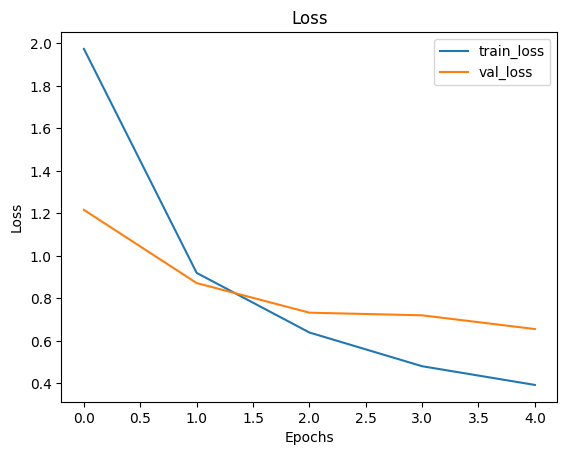

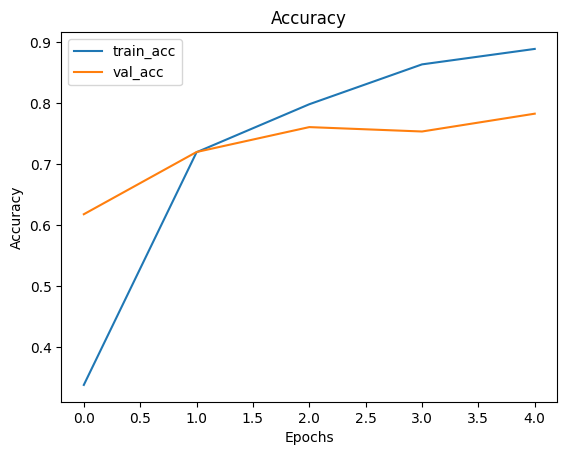

In [ ]:
plot_loss_curves(resnet_history)

##Creating and testing Efficient Net

In [ ]:
# Creating models using Tensorflow Hub
##Effecientnetv2B0 feature vetcor: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [ ]:
# create model
effnet_model = create_model(efficientnet_url, num_classes=train_generator.num_classes)

In [ ]:
# compile the model
effnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [ ]:
# define callback
dir_name='tensorflow_hub'
experiment_name='effnetb0'
tensorboard_callback = create_tensorboard_callback(dir_name, experiment_name)


# fit the model
effnet_history = effnet_model.fit(train_generator,
                                  epochs=5,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=test_generator,
                                  validation_steps=len(test_generator),
                                  callbacks=[tensorboard_callback])

Saving tensorboard log files to: tensorflow_hub/effnetb0/20230627-051740
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8994 - accuracy: 0.4040 - val_loss: 1.3200 - val_accuracy: 0.7240
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0741 - accuracy: 0.7720 - val_loss: 0.8763 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7622 - accuracy: 0.8387 - val_loss: 0.7028 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 21s 889ms/step - loss: 0.6089 - accuracy: 0.8653 - val_loss: 0.6149 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 22s 959ms/step - loss: 0.5133 - accuracy: 0.8800 - val_loss: 0.5614 - val_accuracy: 0.8624


In [ ]:
#evaluate test data
effnet_model.evaluate(test_generator)

79/79 [==============================] - 14s 173ms/step - loss: 0.5614 - accuracy: 0.8624


[0.5614108443260193, 0.8623999953269958]

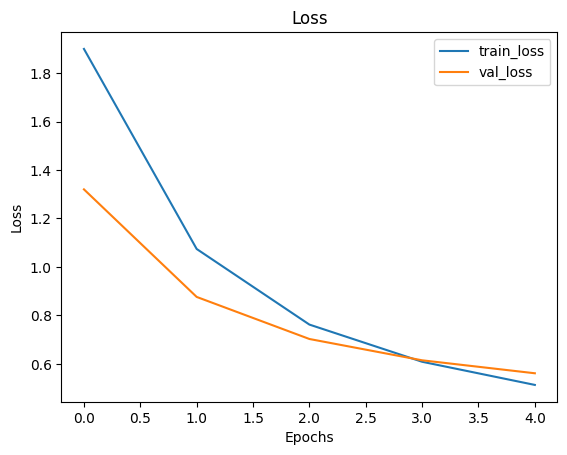

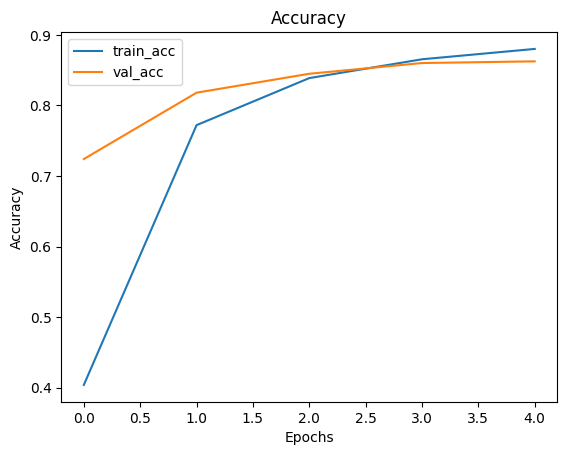

In [ ]:
plot_loss_curves(effnet_history)

EfficientNet outperforms ResNet
- trainable parameters are fewer
- val_acc of 86% compared to 78% of ResNet
- and acc double compared to our VGG CNN explainer architecture used in pervious notebook

In [ ]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
effnet_model.layers

In [ ]:
len(effnet_model.layers[0].weights)

309

In [ ]:
!cp -r /content/tensorflow_hub /content/drive/MyDrive/ColabNotebooks/udemy_tf

##Comparing our model results

In [ ]:
#upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EffNetb0 vs ResNet50V2' \
  --description 'Comparing two different TF Hub feature extraction model architectures' \
  --one_shot

2023-06-27 05:42:47.911979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   PCGZ-KFVK



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

Our TF Hub experiment results are uploaded publicly to Tensorboard here:  https://tensorboard.dev/experiment/L9DOmQzsQim2hkLA90WX0w/

Every time you upload something to TensorBoad.dev you'll get a new experiment ID. The experiment ID will look something like this: https://tensorboard.dev/experiment/73taSKxXQeGPQsNBcVvY3g/ (this is the actual experiment from this notebook).

If you upload the same directory again, you'll get a new experiment ID to go along with it.

This means to track your experiments, you may want to look into how you name your uploads. That way when you find them on TensorBoard.dev you can tell what happened during each experiment (e.g. "efficientnet0_10_percent_data").

### Listing experiments you've saved to TensorBoard

To see all of the experiments you've uploaded you can use the command:

```tensorboard dev list```

In [ ]:
!tensorboard dev list

2023-06-27 05:47:53.556309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/L9DOmQzsQim2hkLA90WX0w/
	Name                 EffNetb0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   L9DOmQzsQim2hkLA90WX0w
	Created              2023-06-27 05:43:24 (4 minutes ago)
	Updated              2023-06-27 05:43:28 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3155276
Total: 1 experiment(s)


### Deleting experiments from TensorBoard

Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

`tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]`



In [ ]:
# Delete an  experiment
!tensorboard dev delete --experiment_id L9DOmQzsQim2hkLA90WX0w

2023-06-27 05:51:48.696745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment L9DOmQzsQim2hkLA90WX0w.


In [ ]:
# Check to see if experiments still exist
!tensorboard dev list # uncomment to see

2023-06-27 05:52:07.202594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No experiments. Use `tensorboard dev upload` to get started.


In [ ]:
#Reupload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EffNetb0 vs ResNet50V2' \
  --description 'Comparing two different TF Hub feature extraction model architectures' \
  --one_shot

2023-06-27 05:52:29.392265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/N2DtNT0pRuqPhyxeK5Copw/

[2023-06-27T05:52:31] Started scanning logdir.
[2023-06-27T05:52:34] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (3.0 MB)
[2023-06-27T05:52:34] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/N2DtNT0pRuqPhyxeK5Copw/


In [ ]:
!tensorboard dev list

2023-06-27 05:53:05.634620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/N2DtNT0pRuqPhyxeK5Copw/
	Name                 EffNetb0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   N2DtNT0pRuqPhyxeK5Copw
	Created              2023-06-27 05:52:31 (36 seconds ago)
	Updated              2023-06-27 05:52:34 (33 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3155276
Total: 1 experiment(s)
